# Football Match Analysis Project

In the world of football, the quantity and quality of available data have significantly increased, offering unique opportunities to analyze the game with unprecedented precision. This project aims to leverage a comprehensive database encompassing all events occurring in numerous matches across various competitions. The goal is to develop a model capable of predicting the outcome of a match based on team compositions and various individual player statistics.

## Data Collection and Preprocessing

The data used in this project comes from `StatsBomb`, a company specializing in sports data analysis. StatsBomb provides detailed data on all football match events, including information on players, teams, gameplay actions, field positions and [expected goals (xG)](https://en.wikipedia.org/wiki/Expected_goals). We have used some of these competitions available for free for this project. The initial phase of our project involved gathering a detailed database, going through each match folder to combine all events from different matches of different competitions into a single `data/events.csv`.

We explored various preprocessing methods to extract valuable insights into player performances. This includes the creation of new advanced metrics:

- **xT (Expected Threat)**: A measure that evaluates the offensive threat or potential generated by a specific on-field action, allowing for an appreciation of a player's contribution beyond traditional statistics.
- **OBV (On-Ball Value)**: A quantitative index of the value of a play, considering the impact of each event (pass, shot, interception, etc.) on the probability of scoring or conceding a goal.

Additionally, we enriched our database with statistics retrieved from other sources, thus adding an extra dimension to our analysis.

Finally, we obtained a comprehensive and ready-to-use database `startingXI` for developing prediction models.

## Project Goals

The project focuses on applying data analysis techniques and predictive modeling to:

1. Understand the key factors influencing the outcome of a match.
2. Quantifiably assess individual player contributions, taking into account all actions on the field.
3. Predict match results based on team compositions and players' previous performances.

Through this approach, we aspire to offer in-depth insights into game dynamics and provide a valuable tool for coaches, analysts, and football enthusiasts.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import optuna

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from xgboost import XGBRegressor

pd.set_option('display.max_columns', None)

from utlis import utils

In [2]:
utils = utils()
events = pd.read_csv("data/events.csv", low_memory=False)

In [3]:
events2 = events.copy()

#### For fast execution, we have reduced the dataset to a competition

In [4]:
# Do not run this cell to work on the whole dataset
events = events[events["competition_season"] == "UEFA Euro_2020"]

In [5]:
events_orig = events.copy()

## Creation of new team form statistics

We have added a "form state" for the teams, which reflects their results over the last three matches.

This was calculated in two different ways. First, by the number of wins, losses, and draws in the last three matches. Then, by the total [expected goals (xG)](https://en.wikipedia.org/wiki/Expected_goals) scored and conceded in the last 3 matches. This allows us to have two distinct metrics to assess the form of the team.

See [utils](utlis.py) for the implementation of these functions: `assign_xg_to_team`, `calculate_total_form_xg`, `calculate_adversary_form_xg` and `calculate_form`.

In [6]:
# Compute the sum of shot.statsbomb_xg for each team per match
team_xg_sum = events.groupby(['match_id', 'team.name'])['shot.statsbomb_xg'].sum().reset_index(name='xg_total')

# Apply the function to assign the xg_total_home and xg_total_away
events[['xg_total_home', 'xg_total_away']] = events.apply(utils.assign_xg_to_team, axis=1, xg_data=team_xg_sum)

# Clean the DataFrame to remove duplicates and keep one line per match with the xG totals
df_final_adjusted = events[['match_id', 'home_team', 'away_team', 'xg_total_home', 'xg_total_away','match_date','home_score','away_score']]
df_final_adjusted.drop_duplicates(inplace=True)
df_final_adjusted.reset_index(drop=True, inplace=True)


/var/folders/hy/27t6v09s54x9lv_68y2yk65w0000gn/T/ipykernel_99043/3449834463.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_adjusted.drop_duplicates(inplace=True)


In [7]:
# Apply the function to calculate the form based on the xG of the opponents for each team
df_final_adjusted['home_adversary_xg'] = utils.calculate_adversary_form_xg(df_final_adjusted, "home_team")
df_final_adjusted['away_adversary_xg'] = utils.calculate_adversary_form_xg(df_final_adjusted, "away_team")

df_final_adjusted['home_form'] = utils.calculate_form(df_final_adjusted, "home_team")
df_final_adjusted['away_form'] = utils.calculate_form(df_final_adjusted, "away_team")

df_final_adjusted.head()

/var/folders/hy/27t6v09s54x9lv_68y2yk65w0000gn/T/ipykernel_99043/680094572.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_adjusted['home_adversary_xg'] = utils.calculate_adversary_form_xg(df_final_adjusted, "home_team")
/var/folders/hy/27t6v09s54x9lv_68y2yk65w0000gn/T/ipykernel_99043/680094572.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_adjusted['away_adversary_xg'] = utils.calculate_adversary_form_xg(df_final_adjusted, "away_team")
/var/folders/hy/27t6v09s54x9lv_68y2yk65w0000

,match_id,home_team,away_team,xg_total_home,xg_total_away,match_date,home_score,away_score,home_adversary_xg,away_adversary_xg,home_form,away_form
0,3795108,Switzerland,Spain,3.957757,6.928069,2021-07-02,1,1,9.514070,3.433525,0,2
1,3788769,Russia,Denmark,1.090950,2.330365,2021-06-21,1,4,2.358408,1.340362,0,-2
2,3788766,Italy,Wales,1.669124,0.240743,2021-06-20,1,0,0.484822,2.870190,2,1
3,3795220,Italy,Spain,4.315651,4.536130,2021-07-06,1,1,3.082092,6.839024,3,2
4,3788761,Sweden,Slovakia,1.583975,0.553248,2021-06-18,1,0,1.927612,1.388840,0,1


<span style="color: red;">We won't use these functions here to add data from another dataset, as we don't have enough data to cover all the players in our main dataset.</span>


We will also be adding player statistics from the previous season using another dataset. Here's how these statistics were calculated:
For each position, we selected the three statistics we found most relevant. For forwards, we chose average goals, shots on target, and assists. For midfielders, non-progressive passes, Shot-Creating Actions (SCA), and passes into the final third. For defenders, interceptions, blocks, and tackles. We then normalized the data by position—attackers with attackers, defenders with defenders, etc.—to rate the players in relation to their position and their peers.

However, the issue arises with the different ways names are written across the two datasets. In the season stats, short names are kept (e.g., Lionel Messi), whereas in the starting XI, full names are used (e.g., Lionel Andres Messi). We attempted to match the short and full names, but due to many players having similar names, we were not able to match all of them accurately.

In [8]:
# player_stats = pd.read_csv("21-22_Player_Stats.csv",
#                            encoding="latin1",
#                            sep=";")

# # Selection of specific columns to display, including statistics for different positions
# columns_to_display = [
#     'Player', 'Nation', 'Pos', 'Squad', 'Comp', '90s', 'Goals', 'SoT', 'Assists',
#     'Int', 'Tkl', 'Blocks', 'PasProg', 'SCA', 'Pas3rd'
# ]

# # Filter the complete dataset to include only the selected columns
# player_stats_specific = player_stats[columns_to_display]

# # Update the statistics columns to 0 for players with less than 2 "90s"
# stats_columns = ['Goals', 'SoT', 'Assists', 'Int',
#                  'Tkl', 'Blocks', 'PasProg', 'SCA', 'Pas3rd']

# player_stats_specific.loc[player_stats_specific['90s'] < 2, stats_columns] = 0

# # Defining the columns to set to zero for each group of positions
# attaquant_columns_to_zero = ['Int', 'Tkl',
#                              'Blocks', 'PasProg', 'SCA', 'Pas3rd']
# milieu_columns_to_zero = ['Goals', 'SoT', 'Assists', 'Int', 'Tkl', 'Blocks']
# defenseur_columns_to_zero = ['Goals', 'SoT',
#                              'Assists', 'PasProg', 'SCA', 'Pas3rd']

# # Attacking players: Set midfielder and defender stats to 0 if the position starts with FW
# player_stats_specific.loc[player_stats_specific['Pos'].str.startswith(
#     'FW'), attaquant_columns_to_zero] = 0

# # Midfielders: Set forward and defender stats to 0 if the position starts with MF
# player_stats_specific.loc[player_stats_specific['Pos'].str.startswith(
#     'MF'), milieu_columns_to_zero] = 0

# # Defenders: Set forward and midfielder stats to 0 if the position starts with DF
# player_stats_specific.loc[player_stats_specific['Pos'].str.startswith(
#     'DF'), defenseur_columns_to_zero] = 0

# # Goalkeepers: Already treated, but this logic doesn't change
# player_stats_specific.loc[player_stats_specific['Pos']
#                           == 'GK', stats_columns] = 0

# # Normalization of the statistics columns
# scaler = MinMaxScaler()
# df_normalized = player_stats_specific
# columns_to_normalize = ['Goals', 'SoT', 'Assists',
#                         'Int', 'Tkl', 'Blocks', 'PasProg', 'SCA', 'Pas3rd']

# df_normalized[columns_to_normalize] = scaler.fit_transform(
#     df_normalized[columns_to_normalize])

# # Correction of the attribution of values for stat1, stat2, stat3 based on the position
# for index, row in df_normalized.iterrows():
#     if row["Pos"].startswith("FW"):
#         df_normalized.at[index, "stat1"] = row["Goals"]
#         df_normalized.at[index, "stat2"] = row["SoT"]
#         df_normalized.at[index, "stat3"] = row["Assists"]

#     elif row['Pos'].startswith('MF'):
#         df_normalized.at[index, "stat1"] = row["PasProg"]
#         df_normalized.at[index, "stat2"] = row["SCA"]
#         df_normalized.at[index, "stat3"] = row["Pas3rd"]

#     elif row['Pos'].startswith('DF'):
#         df_normalized.at[index, "stat1"] = row["Int"]
#         df_normalized.at[index, "stat2"] = row["Tkl"]
#         df_normalized.at[index, "stat3"] = row["Blocks"]

#     elif row['Pos'].startswith('GK'):
#         df_normalized.at[index, "stat1"] = 0
#         df_normalized.at[index, "stat2"] = 0
#         df_normalized.at[index, "stat3"] = 0


# df_normalized.drop(columns=stats_columns, inplace=True)

In [9]:
# moyenne_stat1 = df_normalized['stat1'].mean()
# moyenne_stat2 = df_normalized['stat2'].mean()
# moyenne_stat3 = df_normalized['stat3'].mean()

# print("Moyenne de stat1:", moyenne_stat1)
# print("Moyenne de stat2:", moyenne_stat2)
# print("Moyenne de stat3:", moyenne_stat3)

------

## I. **<ins>Creation of new metrics to quantify the value of an event</ins>**

### Summary on the Importance of Possession State Value Models (PSVM)

Historically, the focus has been on goal scorers as the main contributors of value to a team, as the team that scores the most goals wins a football match. However, this approach is flawed because it does not take into account the fact that scoring opportunities for strikers come mainly from the contributions of their teammates.

The idea of tracking assists as a statistic began to gain popularity, recognising the importance of non-goal events contributing significantly to the game. FIFA did not officially start tracking assists until the 1994 World Cup. While this was a key step in recognising that events leading to goals are worth monitoring, assists are far from a complete solution.

Since the advent of assists, analysts have developed many alternative approaches to try and extend the idea of crediting players for valuable events leading to goals (directly or indirectly) or improving a team's potential to score goals. Examples include key passes, second assists, xG Buildup, xT, and several variations/models of possession status value (PSVM).

PSVM attempts to objectively and quantitatively measure the value of each on-field event by assessing the change in probability of a team scoring and/or conceding as a direct result of the event. There are two key advantages to PSVMs that other common construction metrics cannot adequately account for:

(a) The ability to differentiate between the value of different passes or actions in a chain of possession leading to a goal.

(b) Most importantly, proper consideration of the opportunity cost of attempting high-risk actions and losing the ball.

PSVMs are able to value the impact of losing possession of the ball and appropriately penalise players for losing possession based on the loss of likelihood of scoring a goal, and in most cases go further to penalise players for giving the opposition an opportunity to score a goal.

By evaluating each action in terms of their ability to increase or decrease the team's chances of scoring/conceding, we can obtain objective and quantitative player-level assessments of player contributions to a team's overall performance in matches.

### **In this part of the preprocessing we will try to create 2 new metrics inspired by the work done by $StatsBomb$ :**
- **$xT$** : ***Expected Threat***
- **$OBV$** : ***On-Ball Value***


<br>
<br>
Sources of documentation and inspiration:

- xT : https://karun.in/blog/expected-threat.html
- OBV : [OBV-2022.pdf](OBV-2022.pdf)


### a. <ins>Preprocessing</ins>

In [10]:
events["location"] = events["location"].astype(str)
events = events[events["location"] != "nan"]

In [11]:
# Get subdataframes for each position
events = events[events["type.name"].isin(["Pass","Carry", "Clearance", "Block", "Dribble", "Shot", "Ball Recovery", "Goal Keeper"])]


events["x"] = events["location"].apply(lambda x: x.split(",")[0][1:]).astype(float)
events["y"] = events["location"].apply(lambda x: x.split(",")[1][:-1]).astype(float)

We use the xT zones for the probability of scoring after 5 actions as shown here: https://karun.in/blog/expected-threat.html

In [12]:
prob_rows = np.array([
    [0.2, 0.3, 0.3, 0.3, 0.4, 0.4, 0.5, 0.7, 0.8, 1, 1.3, 1.8, 2.5, 3.7, 4.8, 6, 6.6],
    [0.3, 0.3, 0.4, 0.4, 0.4, 0.4, 0.5, 0.7, 0.8, 1.1, 1.5, 2, 2.9, 4.2, 5.6, 7.5, 6.6],
    [0.3, 0.3, 0.4, 0.4, 0.4, 0.4, 0.6, 0.7, 0.9, 1.2, 1.6, 2.2, 3.4, 4.6, 6.8, 9.4, 10.3],
    [0.4, 0.4, 0.4, 0.4, 0.4, 0.5, 0.6, 0.7, 0.9, 1.2, 1.6, 2.3, 3.4, 4.6, 6.8, 9.9, 12.3],
    [0.4, 0.4, 0.4, 0.4, 0.5, 0.5, 0.6, 0.7, 1, 1.3, 1.7, 2.5, 3.4, 4.8, 6.8, 12.6, 15.8],
    [0.4, 0.5, 0.5, 0.5, 0.5, 0.6, 0.6, 0.8, 0.9, 1.3, 1.7, 2.5, 3.3, 5.2, 8.9, 17.1, 41]
])

# Mirror the probabilities to create a full 12x16 grid
xT_values = np.vstack((prob_rows, np.flipud(prob_rows)))

# Normalize the probabilities to a scale of 0-1 (dividing by 100 since they were given as percentages)
xT_values /= 100

# Inverse the xT values in the axis x
xT_values_reverse = np.fliplr(xT_values)

# Function to map location to xT value
def map_location_to_xT(x,y, xT_values):
    # Map the x and y coordinates to the xT grid
    xT_x = min(int(np.floor(float(x) / 120 * 16)), 15)
    xT_y = min(int(np.floor(float(y) / 80 * 12)), 11)
    return xT_values[xT_y, xT_x]


# Apply the function to the DataFrame
events['xT'] = events.apply(lambda row: map_location_to_xT(row['x'], row['y'], xT_values), axis=1)
events['rev_xT'] = events.apply(lambda row: map_location_to_xT(row['x'], row['y'], xT_values_reverse), axis=1)

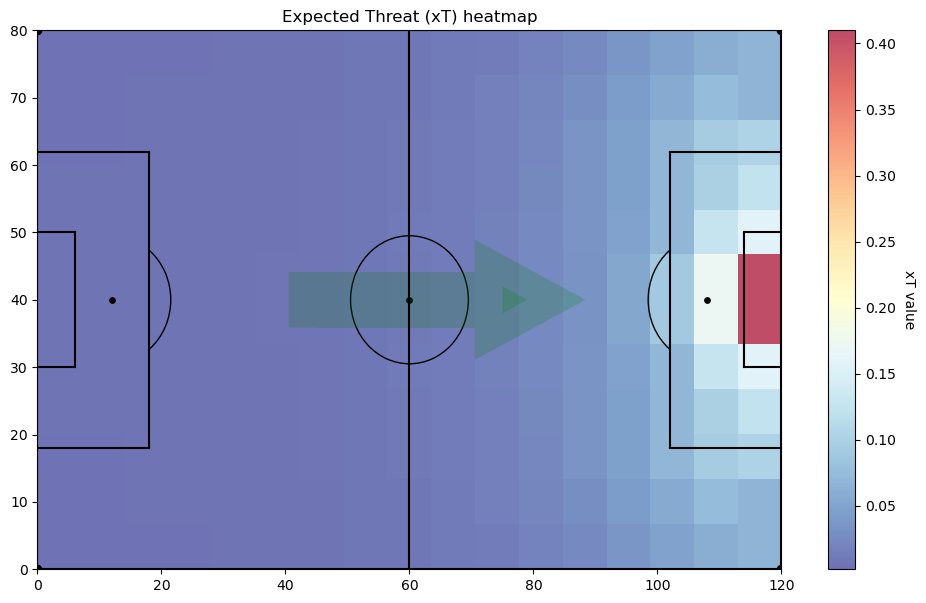

In [13]:
fig, ax = plt.subplots(figsize=(12, 7))
utils.plot_field(ax)

# Plot the xT values
xT_values = np.flipud(xT_values)
im = ax.imshow(xT_values, extent=[0, 120, 0, 80], aspect='auto', cmap='RdYlBu_r', alpha=0.7)
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('xT value', rotation=270, labelpad=15)
ax.arrow(45, 40, 30, 0, head_width=4, head_length=4, fc='green', ec='green', lw=40, alpha=0.2)
plt.title('Expected Threat (xT) heatmap')
plt.show()

In [14]:
# Assign the value 'Complete' to the pass.outcome.name for all the passes with a null value
events.loc[(events["pass.outcome.name"].isnull()) & (events["type.name"] == "Pass"),
           "pass.outcome.name"] = "Complete"

# Assign the value .8 to the pass.outcome.id for all the passes with a null value
events.loc[(events["pass.outcome.id"].isnull()) & (events["type.name"] == "Pass"),
           "pass.outcome.id"] = 8.

# Apply the function to calculate the outcome of the event
events["outcome"] = events.apply(utils.get_outcome, axis=1)

In [15]:
# Apply the function to calculate the end location of the event
events['end_location'] = events.apply(lambda x: utils.get_end_location(x, events), axis=1)

# Apply the function to calculate the end x, y and z of the event
events['end_x'] = events.apply(lambda row: utils.get_end_x(row), axis=1)
events['end_y'] = events.apply(lambda row: utils.get_end_x(row), axis=1)
events['end_z'] = events.apply(lambda row: utils.get_end_z(row), axis=1)

# Apply the function to calculate the xT value
events['xT.end'] = events.apply(lambda row: utils.get_end_xT(row, xT_values), axis=1)
events['xT.from'] = events['xT'].shift(1)

# Calculate the difference in xT between the start and end of the event
events["diff_xT"] = events["xT.end"] - events["xT"]

Now that we have xT, we can evaluate the individual actions of the players in the construction game by calculating `diff_xT` $=$ `xT.end` $-$ `xt` the difference in xT between the starting point and the end point. 

In other words, we'll say that an action that moves the ball from location ( `x` , `y` ) to ( `end_x`, `end_y` ). 


Once again, this has an easy-to-interpret meaning: the value of an action is equal to the percentage change in the team's chances of scoring in the next 5 actions as a result of the action (note that we are using the xT calculated after 5 iterations here, hence "the next 5 actions").


### b. <ins>Possesion 2</ins>: Create a new column recomputing the possession of the teams in the match

Here we create a new `possession_2` variable.

Unlike `possession`, `possession_2` will change after each shot so that no possession contains two shots. 

In [16]:
events["possession_2"] = events["possession"].copy()

# Loop through each unique possession and assign a new value to the possession_2 column
for i in events["possession_2"].unique():
    sub = events[events["possession_2"] == i]

    if "Shot" in sub["type.name"].unique() and sub["type.name"].value_counts()["Shot"] > 1:
        shot_part = sub[sub["type.name"] == "Shot"].index

        for idx in shot_part[:-1]:
            events.loc[idx+2:, "possession_2"] += 1

### c. <ins>Possession State Value For</ins>

This is where we create our label to determine our $OBV$.

For each possession action, we assign the xG value of the shot at the end of that action, or 0 if there was no shot.

This will allow us to train our OBV model to determine which actions are most likely to contribute to the creation of a shot.

In [17]:
events['PSVF'] = .0

# Loop through each unique match
for match in events['match_id'].unique():
    # Identify the index of the shots in the match
    shoot_indices = events[(events['type.name'] == 'Shot') & (events["match_id"] == match)].index

    # Compute the PSV for each shot
    for idx in shoot_indices:
        possession_idx = events.loc[idx, 'possession_2']
        possession_events = events[events['possession_2'] == possession_idx]

        # Compute the total xG for the possession
        total_xG = events.loc[idx]['shot.statsbomb_xg'].astype(float)
        events.loc[(events['possession_2'] == possession_idx) & (events["match_id"] == match ), 'PSVF'] = total_xG

### d. <ins>Possession State Value Against</ins>

In a similar way, here we create an inverted `PSVF`, `PSVA` which assigns the `PSVF` value of the following possession.

This is used to determine which actions tend to result in a shot for the opposing team in the next possession.

In [18]:
events['PSVA'] = .0

# Loop through each unique possession and assign a new value to the possession_2 column
for match in events['match_id'].unique():
    # Identify the index of the shots in the match
    shoot_indices = events[(events['type.name'] == 'Shot') & (
        events["match_id"] == match)].index
    prev_psv = 0

    # Compute the PSVA for each shot
    for i, p in enumerate(events[events["match_id"] == match]["possession"].unique()):
        # Get current possession team and PSV
        tmp_psvf = events.loc[(events['possession'] == p) &
                              (events["match_id"] == match), 'PSVF']
        tmp_team = events.loc[(events['possession'] == p) &
                              (events["match_id"] == match), 'possession_team.name']

        # Get previous possession team and PSV
        prev_team = tmp_team.iloc[0]
        prev_psv = tmp_psvf.iloc[0]

        if len(events.loc[(events["possession"] == p - 1) & (events["match_id"] == match), "PSVF"]) == 0:
            events.loc[(events["possession"] == p - 1) &
                       (events["match_id"] == match), "PSVA"] = 0

        elif (events.loc[(events["possession"] == p - 1) & (events["match_id"] == match), "possession_team.name"].iloc[0]) == prev_team:
            events.loc[(events["possession"] == p - 1) &
                       (events["match_id"] == match), "PSVA"] = 0

        else:
            events.loc[(events["possession"] == p - 1) &
                       (events["match_id"] == match), "PSVA"] = prev_psv

Feature engeenering on `x` and `y` to obtain `distance_to_goal` and `angle_to_goal` 

In [19]:
events.fillna(0, inplace=True)

# Create a new column for the distance to goal
events['distance_to_goal'] = ((events['x'] - 120)**2 + (events['y'] - 40)**2)**0.5

# Create a new column for the angle to goal
a2 = ((events['x'] - 120)**2 + (events['y'] - 40-3.66)**2)
c2 = ((events['x'] - 120)**2 + (events['y'] - 40 + 3.66)**2)

# Calculate the angle to goal
events['angle_to_goal'] = np.degrees(np.arccos((a2 + c2 - (7.3)**2)/(2*(a2**0.5)*(c2**0.5))))


/var/folders/hy/27t6v09s54x9lv_68y2yk65w0000gn/T/ipykernel_99043/3877652997.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  events['distance_to_goal'] = ((events['x'] - 120)**2 + (events['y'] - 40)**2)**0.5
/Users/thomassinapi/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/hy/27t6v09s54x9lv_68y2yk65w0000gn/T/ipykernel_99043/3877652997.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  

### e. <ins>Data Selection</ins>

Before training our model, we extract informative data from our dataset.

For example `pass.shot_assist` informs us of the action to be taken on a shot and therefore helps the model. We only want to know about one action and no more to really assess the value of an action. 


We therefore keep `PSVF` as a label for our regression model and the predicted values will give us the $OBV$ of an action

In [20]:
# Select the columns to drop
column_name = events.columns[events.columns.str.endswith("name")]
end_location = events.columns[events.columns.str.endswith("end_location")]
to_drop = [*column_name, *end_location] + ["id", "index", "match_id", "match_date", "period", "player.id", "player.name",
                                           "substitution.replacement.id", "substitution.replacement.name",
                                           "match_outcome", "minute", "second", "possession", "possession_2",
                                           "competition_season", "timestamp", "half_start.late_video_start",
                                           "injury_stoppage.in_chain", "bad_behaviour.card.id",
                                           "tactics.lineup", "tactics.formation", "player.id", "pass.recipient.id",
                                           "related_events", "location", "PSVF", "shot.aerial_won", "PSVA", "shot.statsbomb_xg",
                                           "pass.shot_assist", "pass.goal_assist", "pass.assisted_shot_id"
                                           ]


# Select the features and the target
X = events.drop(to_drop, axis=1)
y = events["PSVF"]

# Transform the categorical variables into numerical variables
for col in X.columns:
    if X[col].dtype == "object":
        X[col] = pd.Categorical(X[col]).codes

### f. <ins>Building Model</ins>

In [21]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the model
model = XGBRegressor(random_state=42)
model.fit(X_train, y_train)

# Predict the PSV
y_pred = model.predict(X_test)

# Evaluate the model
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))

Mean Squared Error: 0.0032702629132428615
R2 Score: 0.28032621165317706


We obtain an R2 of `0.28`, bearing in mind that it is very difficult to predict the value of a football actions.

For the time being, we are satisfied with these results, which can be refined and improved.

### g. <ins>Predicting the On-Ball Value</ins>

We therefore attribute the model's predictions to our entire dataset.

In [22]:
# Predict the OBV
obv_pred = model.predict(X)
r2_score(y, obv_pred)

# Assign the predicted OBV to the DataFrame
X["OBV"] = obv_pred

We perform a join with the original dataset to recover all the columns

In [24]:
# Concatenate the events DataFrame with the OBV values
events_obv = pd.concat([events_orig, X[["OBV", "xT", "xT.end", "rev_xT"]]], axis=1)
events_obv["diff_xT"] = events_obv["xT.end"] - events_obv["xT"]



# II. **<ins>Creation of the base dataset</ins>**

Pre-storage of the number of appearances, goals, clearances, key passes, decisive passes, obv sums, diff_xT sums for each player 

In [25]:
# Extract the names of the players from the tactics lineup
lineup = events_obv[events_obv["type.name"] == "Starting XI"]

# Define the defensive players positions
defensive_players = ["Right Center Back", 
                     "Left Center Back", 
                     "Right Back", 
                     "Left Back",
                     "Center Back",
                     "Left Defensive Midfield", 
                     "Right Defensive Midfield", 
                     "Right Wing Back","Left Wing Back"]


# Create a cache to store player statistics
player_cache_appearances = {}
player_cache_clearance = {}
player_cache_keypass = {}
player_cache_assist = {}
player_cache_goals = {}
player_cache_obv = {}
player_cache_diff_xT = {}

# Define the columns of the dataframe
columns = ["match_id", "competition_season", "match_date", "match_outcome"]
columns += [f"player_{i}" for i in range(1, 23)]

# Create a dataframe to store the starting XI
startingXI = pd.DataFrame(columns=columns)

This code is used to retrieve, for each player in a given match, his various statistics from previous matches.

In [26]:
# Iterate over each match date in the lineup dataframe
for match_date in lineup['match_date'].unique():
    # Get all events before the match date
    event_prev = events[events['match_date'] < match_date]

    # Get the lineup for the match date
    lineups_for_date = lineup[lineup["match_date"] == match_date]["tactics.lineup"]
    
    # Get the goals conceded by the goalkeepers
    goals_conceded = event_prev[(event_prev["goalkeeper.type.name"] == "Goal Conceded") | (event_prev["goalkeeper.type.name"] == "Penalty Conceded")]

    # Get the number of key passes and assists
    pass_ = (event_prev["type.name"] == "Pass")
    match_keypass = event_prev[pass_ & (event_prev["pass.assisted_shot_id"].notnull())]
    match_assists = event_prev[pass_ & (event_prev["pass.goal_assist"] == True)]

    # Get the number of Ball Recovery, Clearance and Blocks
    match_recovers = event_prev[(event_prev["type.name"] == "Ball Recovery")]
    match_clearance = event_prev[(event_prev["type.name"] == "Clearance")]
    match_blocks = event_prev[(event_prev["type.name"] == "Block")]

    # Get the number of duels won
    match_duels = event_prev[(event_prev["type.name"] == "Duel") & (event_prev["duel.outcome.name"] == "Won")]

    # Get the number of goals scored
    match_goals = event_prev[event_prev["shot.outcome.name"] == "Goal"]

    for tactics_lineup in lineups_for_date:
        tactics_lineup = eval(tactics_lineup)
        player_names = utils.extract_player_names(tactics_lineup)
        player_positions = utils.extract_player_position(tactics_lineup)

        # Map the players to their positions
        player_to_position = dict(zip(player_names, player_positions))

        for player, position in player_to_position.items():
            # Get the number of appearances by the players
            player_cache_appearances[(player, match_date)] = event_prev[event_prev["player.name"] == player].groupby('match_id').first().reset_index().shape[0]
            
            # Get the number of assists and key passes by the players
            player_cache_assist[(player, match_date)] = match_assists[match_assists["player.name"] == player].shape[0]
            
            # Get the number of key passes by the players
            player_cache_keypass[(player, match_date)] = match_keypass[match_keypass["player.name"] == player].shape[0]
            
            player_cache_obv[(player, match_date)] = events_obv[events_obv["player.name"] == player]["OBV"].sum()

            player_cache_diff_xT[(player, match_date)] = events_obv[events_obv["player.name"] == player]["diff_xT"].sum()

            # Store the number of goals conceded by the goalkeepers
            if position == "Goalkeeper":
                player_cache_goals[(player, match_date)] = goals_conceded[goals_conceded["player.name"] == player].shape[0]
            
            
            # Store the number of defensive actions by the players
            elif position in defensive_players:
                # Assign a weight to each defensive action
                clearance = match_clearance[match_clearance["player.name"] == player].shape[0] * .2
                blocks = match_blocks[match_blocks["player.name"] == player].shape[0] * .2
                recovers = match_recovers[match_recovers["player.name"] == player].shape[0] * .3
                duels = match_duels[match_duels["player.name"] == player].shape[0] * .3

                # Store the sum of all defensive actions
                player_cache_goals[(player, match_date)] = clearance + recovers + duels + blocks
            
            # Store the number of goals scored by the players
            elif not position in defensive_players:
                player_cache_goals[(player, match_date)] = match_goals[match_goals["player.name"] == player].shape[0]


We add all these player stats for each match to our dataset, which will then be composed of stats on the form of each team and the 5 additional stats for the 22 players in a match

In [27]:
# Reset the index of the starting XI dataframe
lineup.reset_index(drop=True, inplace=True)

for i in range(0, len(lineup), 2):
    # Extract the lineup for each team
    team1_lineup = eval(lineup["tactics.lineup"][i])
    team2_lineup = eval(lineup["tactics.lineup"][i + 1])

    # Check if the lineup is complete
    if len(team1_lineup) < 11 or len(team2_lineup) < 11:
        continue

    # Extract the names of the players from the tactics lineup
    player_names = utils.extract_player_names(team1_lineup) + utils.extract_player_names(team2_lineup)
    player_positions = utils.extract_player_position(team1_lineup) + utils.extract_player_position(team2_lineup)
    
    lineup_data = {
        "match_id": lineup["match_id"][i],
        "competition_season": lineup["competition_season"][i],
        "match_date": lineup["match_date"][i],
        "match_outcome": lineup["match_outcome"][i],

        **{f"player_{j+1}": player_names[j] for j in range(22)},

        **{f"player_{j+1}_position": player_positions[j] for j in range(22)},

        **{
            f"player_{j+1}_goals": (
                player_cache_goals.get((player_names[j], lineup["match_date"][i]), 0) /
                player_cache_appearances.get((player_names[j], lineup["match_date"][i]), 1)
                if player_cache_appearances.get((player_names[j], lineup["match_date"][i]), 1) != 0 else 0
            ) for j in range(22)
        },

        **{
            f"player_{j+1}_assists": (
                player_cache_assist.get((player_names[j], lineup["match_date"][i]), 0) /
                player_cache_appearances.get(
                    (player_names[j], lineup["match_date"][i]), 1)
                if player_cache_appearances.get((player_names[j], lineup["match_date"][i]), 1) != 0 else 0
            ) for j in range(22)
        },

        **{
            f"player_{j+1}_keypass": (
                player_cache_keypass.get((player_names[j], lineup["match_date"][i]), 0) /
                player_cache_appearances.get(
                    (player_names[j], lineup["match_date"][i]), 1)
                if player_cache_appearances.get((player_names[j], lineup["match_date"][i]), 1) != 0 else 0
            ) for j in range(22)
        }, 
        **{
            f"player_{j+1}_obv": (
                player_cache_obv.get((player_names[j], lineup["match_date"][i]), 0) /
                player_cache_appearances.get(
                    (player_names[j], lineup["match_date"][i]), 1)
                if player_cache_appearances.get((player_names[j], lineup["match_date"][i]), 1) != 0 else 0
            ) for j in range(22)
        },
        **{
            f"player_{j+1}_diff_xT": (
                player_cache_diff_xT.get((player_names[j], lineup["match_date"][i]), 0) /
                player_cache_appearances.get(
                    (player_names[j], lineup["match_date"][i]), 1)
                if player_cache_appearances.get((player_names[j], lineup["match_date"][i]), 1) != 0 else 0
            ) for j in range(22)
        }
    }

    startingXI = pd.concat([startingXI, pd.DataFrame([lineup_data])], ignore_index=True)

<span style="color: red;">We won't use these functions here to add data from another dataset, as we don't have enough data to cover all the players in our main dataset.</span>

In [28]:
# xi_wc_new = startingXI

# # Extract the names of the players from the tactics lineup
# player_columns = [f'player_{i}' for i in range(1, 23)]
# unique_players = xi_wc_new[player_columns].melt(value_name='Player')['Player'].unique()

# # Create a DataFrame with the unique players
# unique_players_df = pd.DataFrame(unique_players, columns=['Player'])
# unique_players_df.rename(columns={'Player': 'player_full'}, inplace=True)
# unique_players_df

In [29]:
# stats_cleaned = df_normalized.drop_duplicates(subset=['Player'], keep='first')
# stats_cleaned

In [30]:
# # Imaginons que vous avez deux DataFrames: unique_players_df et stats_cleaned
# # avec les colonnes 'player_full' et 'Player' respectivement.

# # Fonction pour vérifier si deux chaînes de caractères ont au moins deux mots en commun
# def have_two_words_in_common(name1, name2):
#     # Séparer les noms en mots, en enlevant les éventuels tirets
#     words_name1 = set(name1.lower().replace("-", " ").split())
#     words_name2 = set(name2.lower().replace("-", " ").split())
    
#     # Compter le nombre de mots en commun
#     common_words = words_name1.intersection(words_name2)
    
#     # Vérifier si au moins deux mots sont en commun
#     return len(common_words) >= 2

# # Préparer une DataFrame pour la fusion
# merged_rows = []

# # Itérer sur chaque combinaison de lignes entre les deux DataFrames
# for i, row1 in unique_players_df.iterrows():
#     for j, row2 in stats_cleaned.iterrows():
#         # Appliquer la fonction de vérification
#         if have_two_words_in_common(row1['player_full'], row2['Player']):
#             # Si correspondance, ajouter la combinaison des deux lignes à merged_rows
#             merged_rows.append(row1.to_dict() | row2.to_dict())  # Utiliser l'union de dictionnaires (Python 3.9+)

# # Convertir la liste des lignes fusionnées en DataFrame
# merged_df = pd.DataFrame(merged_rows)

# # Afficher le résultat
# print(merged_df)


In [31]:
# # Créer une copie de xi_wc_new pour ne pas modifier l'original pendant le processus
# xi_wc_new_extended = startingXI.copy()

# # Préparer les colonnes de statistiques pour chaque joueur dans xi_wc_new
# for i in range(1, 23):  # Pour chaque joueur de player_1 à player_22
#     player_column = f'player_{i}'
#     # Créer les noms des colonnes pour les statistiques
#     stat1_column = f'stat1_player_{i}'
#     stat2_column = f'stat2_player_{i}'
#     stat3_column = f'stat3_player_{i}'
    
#     # Initialiser les colonnes de statistiques avec 0.0 (float) au lieu de 0 (int)
#     xi_wc_new_extended[stat1_column] = moyenne_stat1
#     xi_wc_new_extended[stat2_column] = moyenne_stat2
#     xi_wc_new_extended[stat3_column] = moyenne_stat3
    
#     # Pour chaque ligne dans xi_wc_new, chercher les statistiques du joueur correspondant dans merged_df
#     for index, row in xi_wc_new_extended.iterrows():
#         player_name = row[player_column]
#         # Trouver le joueur dans merged_df
#         player_stats = merged_df[merged_df['player_full'] == player_name]
#         if not player_stats.empty:
#             # Si le joueur est trouvé, mettre à jour les statistiques avec un cast explicite en float si nécessaire
#             xi_wc_new_extended.at[index, stat1_column] = float(player_stats['stat1'].values[0])
#             xi_wc_new_extended.at[index, stat2_column] = float(player_stats['stat2'].values[0])
#             xi_wc_new_extended.at[index, stat3_column] = float(player_stats['stat3'].values[0])
#         # Si le joueur n'est pas trouvé, les statistiques restent à 0.0 (déjà initialisées)

# xi_wc_new_extended


In [32]:
# merge df aveec xi_wc_new_extended
# startingXI = df_final_adjusted.merge(startingXI, on=["match_id", "match_date"], how="left")

----

### <ins>Saving the dataset used for the challenge</ins>

Here is the final dataset

In [33]:
startingXI.head()

,match_id,competition_season,match_date,match_outcome,player_1,player_2,player_3,player_4,player_5,player_6,player_7,player_8,player_9,player_10,player_11,player_12,player_13,player_14,player_15,player_16,player_17,player_18,player_19,player_20,player_21,player_22,player_1_position,player_2_position,player_3_position,player_4_position,player_5_position,player_6_position,player_7_position,player_8_position,player_9_position,player_10_position,player_11_position,player_12_position,player_13_position,player_14_position,player_15_position,player_16_position,player_17_position,player_18_position,player_19_position,player_20_position,player_21_position,player_22_position,player_1_goals,player_2_goals,player_3_goals,player_4_goals,player_5_goals,player_6_goals,player_7_goals,player_8_goals,player_9_goals,player_10_goals,player_11_goals,player_12_goals,player_13_goals,player_14_goals,player_15_goals,player_16_goals,player_17_goals,player_18_goals,player_19_goals,player_20_goals,player_21_goals,player_22_goals,player_1_assists,player_2_assists,player_3_assists,player_4_assists,player_5_assists,player_6_assists,player_7_assists,player_8_assists,player_9_assists,player_10_assists,player_11_assists,player_12_assists,player_13_assists,player_14_assists,player_15_assists,player_16_assists,player_17_assists,player_18_assists,player_19_assists,player_20_assists,player_21_assists,player_22_assists,player_1_keypass,player_2_keypass,player_3_keypass,player_4_keypass,player_5_keypass,player_6_keypass,player_7_keypass,player_8_keypass,player_9_keypass,player_10_keypass,player_11_keypass,player_12_keypass,player_13_keypass,player_14_keypass,player_15_keypass,player_16_keypass,player_17_keypass,player_18_keypass,player_19_keypass,player_20_keypass,player_21_keypass,player_22_keypass,player_1_obv,player_2_obv,player_3_obv,player_4_obv,player_5_obv,player_6_obv,player_7_obv,player_8_obv,player_9_obv,player_10_obv,player_11_obv,player_12_obv,player_13_obv,player_14_obv,player_15_obv,player_16_obv,player_17_obv,player_18_obv,player_19_obv,player_20_obv,player_21_obv,player_22_obv,player_1_diff_xT,player_2_diff_xT,player_3_diff_xT,player_4_diff_xT,player_5_diff_xT,player_6_diff_xT,player_7_diff_xT,player_8_diff_xT,player_9_diff_xT,player_10_diff_xT,player_11_diff_xT,player_12_diff_xT,player_13_diff_xT,player_14_diff_xT,player_15_diff_xT,player_16_diff_xT,player_17_diff_xT,player_18_diff_xT,player_19_diff_xT,player_20_diff_xT,player_21_diff_xT,player_22_diff_xT
0,3795108,UEFA Euro_2020,2021-07-02,0,Yann Sommer,Silvan Widmer,Nico Elvedi,Manuel Obafemi Akanji,Ricardo Iván Rodríguez Araya,Denis Lemi Zakaria Lako Lado,Remo Freuler,Breel-Donald Embolo,Xherdan Shaqiri,Steven Zuber,Haris Seferović,Unai Simón Mendibil,César Azpilicueta Tanco,Aymeric Laporte,Pau Francisco Torres,Jordi Alba Ramos,Sergio Busquets i Burgos,Jorge Resurrección Merodio,Pedro González López,Ferrán Torres García,Pablo Sarabia García,Álvaro Borja Morata Martín,Goalkeeper,Right Back,Right Center Back,Left Center Back,Left Back,Right Center Midfield,Left Center Midfield,Right Wing,Center Attacking Midfield,Left Wing,Center Forward,Goalkeeper,Right Back,Right Center Back,Left Center Back,Left Back,Center Defensive Midfield,Right Center Midfield,Left Center Midfield,Right Wing,Left Wing,Center Forward,3.0,0.833333,1.875,2.425000,1.5,0.00,0.00,0.25,0.5,0.0,0.75,0.75,2.50,1.5,1.35,2.075,0.0,0.0,0.00,0.5,0.5,0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.25,1.333333,0.00,0.0,0.0,0.0,0.25,0.25,0.0,0.0,0.0,0.25,0.25,0.0,30.0,38.0,51.5,61.25,59.0,10.0,55.75,27.000000,31.5,33.666667,20.50,30.75,77.500000,98.5,66.5,88.5,73.0,80.5,77.5,21.75,33.5,26.0,4.659414,1.085631,1.161130,1.904172,1.971004,0.698112,1.470452,1.578202,1.377497,1.432731,1.189649,4.909720,5.163518,5.976866,4.899526,6.025733,6.891412,4.554177,6.527637,1.857481,2.857230,3.208010,0.0240,-0.004667,0.1110,0.076,0.15475,-0.0200,0.03475,-0.36725,-0.0030,-0.2440,-0.21375,-0.0535,-0.0120,0.31475,0.0985,-0.1420,-0.060500,-0.02225,-0.08675,-0.2297

In [34]:
# Get X and y data
X = startingXI.drop(["match_outcome"], axis=1)
y = startingXI["match_outcome"].apply(np.sign)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Concatenate the X and y
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

# Save the data
train.to_csv("data/train.csv", index=False)
test.to_csv("data/test.csv", index=False)

## III. **<ins>Example of the use of the base dataset</ins>**

In [35]:
# Load the data
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

# Select the features and the target
X_train_ = train.drop("match_outcome", axis=1)
y_train_ = train["match_outcome"]

X_test = test.drop("match_outcome", axis=1)
y_test = test["match_outcome"]

In [36]:
X_train, X_val, y_train, y_val = train_test_split(X_train_, y_train_, test_size=0.2, random_state=42)

### a. <ins>Preprocessing</ins>

In [37]:
# Data Selection
X_train_.drop(columns=["match_id", "competition_season", "match_date"], inplace=True)
X_train.drop(columns=["match_id", "competition_season", "match_date"], inplace=True)
X_val.drop(columns=["match_id", "competition_season", "match_date"], inplace=True)
X_test.drop(columns=["match_id", "competition_season", "match_date"], inplace=True)

# Fill the missing values with 0
X_train_.fillna(0, inplace=True)
X_train.fillna(0, inplace=True)
X_val.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)


In [38]:
# Remove categorical columns
categorical_columns = X_train.columns[X_train.dtypes == "object"]
X_train_.drop(columns=categorical_columns, inplace=True)
X_train.drop(columns=categorical_columns, inplace=True)
X_val.drop(columns=categorical_columns, inplace=True)
X_test.drop(columns=categorical_columns, inplace=True)

### b. <ins>Bulding the model</ins>

In [39]:
def objective(trial):
    # Define the hyperparameters to optimize for the RandomForestClassifier
    trial.suggest_int("n_estimators", 50, 150)
    trial.suggest_int("max_depth", 3, 15)
    trial.suggest_int("min_samples_split", 2, 40)
    trial.suggest_int("min_samples_leaf", 1, 20)
    trial.suggest_categorical("max_features", [None, "sqrt", "log2"])

    # Create the model
    model = RandomForestClassifier(**trial.params, random_state=0, class_weight="balanced")
    model.fit(X_train, y_train)

    # Predict the target
    y_pred = model.predict(X_test)

    return balanced_accuracy_score(y_test, y_pred)

In [40]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

[I 2024-03-04 23:03:29,607] A new study created in memory with name: no-name-ee0994b9-fb62-42d7-bfb5-fc205587f115
[I 2024-03-04 23:03:29,672] Trial 0 finished with value: 0.3333333333333333 and parameters: {'n_estimators': 139, 'max_depth': 9, 'min_samples_split': 40, 'min_samples_leaf': 17, 'max_features': 'log2'}. Best is trial 0 with value: 0.3333333333333333.
[I 2024-03-04 23:03:29,727] Trial 1 finished with value: 0.3333333333333333 and parameters: {'n_estimators': 139, 'max_depth': 15, 'min_samples_split': 28, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.3333333333333333.
[I 2024-03-04 23:03:29,759] Trial 2 finished with value: 0.3333333333333333 and parameters: {'n_estimators': 71, 'max_depth': 9, 'min_samples_split': 32, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.3333333333333333.
[I 2024-03-04 23:03:29,795] Trial 3 finished with value: 0.3333333333333333 and parameters: {'n_estimators': 79, 'max_depth': 6, 'mi

### d. <ins>Conclusion</ins>

In [41]:
model = RandomForestClassifier(**study.best_params,
                               random_state=42, class_weight="balanced", n_jobs=-1)

model.fit(X_train_, y_train_)
y_pred = model.predict(X_val)

print("Balanced Accuracy Score:", balanced_accuracy_score(y_val, y_pred))

Balanced Accuracy Score: 0.3333333333333333


In [42]:
!ramp-test --submission starting_kit

Testing Team Football Challenge
Reading train and test files from ./data/ ...
Reading cv ...
Training submissions/starting_kit ...
CV fold 0
	score  bal_acc    acc      time
	train    0.333  0.406  0.159289
	valid    0.333  0.375  0.011153
	test     0.333  0.545  0.010558
CV fold 1
	score  bal_acc    acc      time
	train    0.333  0.406  0.032193
	valid    0.333  0.375  0.011929
	test     0.333  0.545  0.010770
CV fold 2
	score  bal_acc    acc      time
	train    0.333  0.406  0.034901
	valid    0.333  0.375  0.010785
	test     0.333  0.545  0.009846
----------------------------
Mean CV scores
----------------------------
	score      bal_acc          acc        time
	train  0.333 ± 0.0  0.406 ± 0.0  0.1 ± 0.06
	valid  0.333 ± 0.0  0.375 ± 0.0   0.0 ± 0.0
	test   0.333 ± 0.0  0.545 ± 0.0   0.0 ± 0.0
----------------------------
Bagged scores
----------------------------
	score  bal_acc    acc
	valid    0.333  0.350
	test     0.333  0.545
